# Data Augmentation & Feature Reduction

* Testing augmenting data for `time_to_failure` in a certain range, e.g., adding sample with a ttf that is $\geq 10$.
* Unlike the original kernel, for augmented data, the out-of-fold MAE is computed ONLY for first 4194 segments.

Reference
* [Basic Data Augmentation & Feature Reduction](https://www.kaggle.com/bigironsphere/basic-data-augmentation-feature-reduction)
* [HyperOpt by BigIronSphere](https://www.kaggle.com/bigironsphere/parameter-tuning-in-one-function-with-hyperopt)

In [116]:
import os
path = os.listdir("../input")
print(path)

['lanl-earthquake-nonmagic-features', 'lanl-earthquakes-try-to-find-magic-features', 'lanl-features', 'LANL-Earthquake-Prediction']


In [3]:
import numpy as np
import pandas as pd
import numpy.random
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
#import required packages
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import gc
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from hyperopt.pyll.stochastic import sample
#optional but advised
import warnings
warnings.filterwarnings('ignore')

#GLOBAL HYPEROPT PARAMETERS
NUM_EVALS = 1000 #number of hyperopt evaluation rounds
N_FOLDS = 5 #number of cross-validation folds on data in each evaluation round

#LIGHTGBM PARAMETERS
LGBM_MAX_LEAVES = 2**10 #maximum number of leaves per tree for LightGBM
LGBM_MAX_DEPTH = 25 #maximum tree depth for LightGBM
EVAL_METRIC_LGBM_REG = 'mae' #LightGBM regression metric. Note that 'rmse' is more commonly used 
EVAL_METRIC_LGBM_CLASS = 'auc'#LightGBM classification metric

#XGBOOST PARAMETERS
XGB_MAX_LEAVES = 2**12 #maximum number of leaves when using histogram splitting
XGB_MAX_DEPTH = 25 #maximum tree depth for XGBoost
EVAL_METRIC_XGB_REG = 'mae' #XGBoost regression metric
EVAL_METRIC_XGB_CLASS = 'auc' #XGBoost classification metric

#CATBOOST PARAMETERS
CB_MAX_DEPTH = 8 #maximum tree depth in CatBoost
OBJECTIVE_CB_REG = 'MAE' #CatBoost regression metric
OBJECTIVE_CB_CLASS = 'Logloss' #CatBoost classification metric

#OPTIONAL OUTPUT
BEST_SCORE = 0

def quick_hyperopt(data, labels, package='lgbm', num_evals=NUM_EVALS, diagnostic=False, Class=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                         'num_leaves',
                          'max_bin',
                         'min_data_in_leaf',
                         'min_data_in_bin']
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            if Class:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=True,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_CLASS, seed=42)
                best_loss = 1 - cv_results['auc-mean'][-1]
                
            else:
                cv_results = lgb.cv(space_params, train, nfold = N_FOLDS, stratified=False,
                                    early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
                best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
        
        if Class:
            metric_list = ['auc'] #modify as required for other classification metrics
            objective_list = ['binary', 'cross_entropy']
        
        else:
            metric_list = ['MAE', 'RMSE'] 
            objective_list = ['huber', 'gamma', 
                              'fair', 'tweedie']
        
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-mae-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['MAE', 'RMSE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:linear', 'reg:gamma', 'reg:tweedie']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : -1
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #CatBoost
    #==========
    
    if package=='cb':
        
        print('Running {} rounds of CatBoost parameter optimisation:'.format(num_evals))
        
        #clear memory 
        gc.collect()
            
        integer_params = ['depth',
                          #'one_hot_max_size', #for categorical data
                          'min_data_in_leaf',
                          'max_bin']
        
        def objective(space_params):
                        
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract nested conditional parameters
            if space_params['bootstrap_type']['bootstrap_type'] == 'Bayesian':
                bagging_temp = space_params['bootstrap_type'].get('bagging_temperature')
                space_params['bagging_temperature'] = bagging_temp
                
            if space_params['grow_policy']['grow_policy'] == 'LossGuide':
                max_leaves = space_params['grow_policy'].get('max_leaves')
                space_params['max_leaves'] = int(max_leaves)
                
            space_params['bootstrap_type'] = space_params['bootstrap_type']['bootstrap_type']
            space_params['grow_policy'] = space_params['grow_policy']['grow_policy']
                           
            #random_strength cannot be < 0
            space_params['random_strength'] = max(space_params['random_strength'], 0)
            #fold_len_multiplier cannot be < 1
            space_params['fold_len_multiplier'] = max(space_params['fold_len_multiplier'], 1)
                       
            #for classification set stratified=True
            cv_results = cb.cv(train, space_params, fold_count=N_FOLDS, 
                             early_stopping_rounds=25, stratified=False, partition_random_seed=42)
           
            best_loss = cv_results['test-MAE-mean'].iloc[-1] #'test-RMSE-mean' for RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = cv_results['test-Logloss-mean'].iloc[-1]
            #if necessary, replace 'test-Logloss-mean' with 'test-[your-preferred-metric]-mean'
            
            return{'loss':best_loss, 'status': STATUS_OK}
        
        train = cb.Pool(data, labels.astype('float32'))
        
        #integer and string parameters, used with hp.choice()
        bootstrap_type = [{'bootstrap_type':'Poisson'}, 
                           {'bootstrap_type':'Bayesian',
                            'bagging_temperature' : hp.loguniform('bagging_temperature', np.log(1), np.log(50))},
                          {'bootstrap_type':'Bernoulli'}] 
        LEB = ['No', 'AnyImprovement', 'Armijo'] #remove 'Armijo' if not using GPU
        #score_function = ['Correlation', 'L2', 'NewtonCorrelation', 'NewtonL2']
        grow_policy = [{'grow_policy':'SymmetricTree'},
                       {'grow_policy':'Depthwise'},
                       {'grow_policy':'Lossguide',
                        'max_leaves': hp.quniform('max_leaves', 2, 32, 1)}]
        eval_metric_list_reg = ['MAE', 'RMSE', 'Poisson']
        eval_metric_list_class = ['Logloss', 'AUC', 'F1']
        #for classification change line below to 'eval_metric_list = eval_metric_list_class'
        eval_metric_list = eval_metric_list_reg
                
        space ={'depth': hp.quniform('depth', 2, CB_MAX_DEPTH, 1),
                'max_bin' : hp.quniform('max_bin', 1, 32, 1), #if using CPU just set this to 254
                'l2_leaf_reg' : hp.uniform('l2_leaf_reg', 0, 5),
                'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 1, 50, 1),
                'random_strength' : hp.loguniform('random_strength', np.log(0.005), np.log(5)),
                #'one_hot_max_size' : hp.quniform('one_hot_max_size', 2, 16, 1), #uncomment if using categorical features
                'bootstrap_type' : hp.choice('bootstrap_type', bootstrap_type),
                'learning_rate' : hp.uniform('learning_rate', 0.05, 0.25),
                'eval_metric' : hp.choice('eval_metric', eval_metric_list),
                'objective' : OBJECTIVE_CB_REG,
                #'score_function' : hp.choice('score_function', score_function), #crashes kernel - reason unknown
                'leaf_estimation_backtracking' : hp.choice('leaf_estimation_backtracking', LEB),
                'grow_policy': hp.choice('grow_policy', grow_policy),
                #'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),# CPU only
                'fold_len_multiplier' : hp.loguniform('fold_len_multiplier', np.log(1.01), np.log(2.5)),
                'od_type' : 'Iter',
                'od_wait' : 25,
                'task_type' : 'GPU',
                'verbose' : 0
            }
        
        #optional: run CatBoost without GPU
        #uncomment line below
        #space['task_type'] = 'CPU'
            
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        #unpack nested dicts first
        best['bootstrap_type'] = bootstrap_type[best['bootstrap_type']]['bootstrap_type']
        best['grow_policy'] = grow_policy[best['grow_policy']]['grow_policy']
        best['eval_metric'] = eval_metric_list[best['eval_metric']]
        
        #best['score_function'] = score_function[best['score_function']] 
        #best['leaf_estimation_method'] = LEM[best['leaf_estimation_method']] #CPU only
        best['leaf_estimation_backtracking'] = LEB[best['leaf_estimation_backtracking']]        
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    else:
        print('Package not recognised. Please use "lgbm" for LightGBM, "xgb" for XGBoost or "cb" for CatBoost.')              

In [6]:
def quick_kfold_imp(X, y, test=None, params=None, n_fold=6, random_state=1127):
    
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    test_preds = np.zeros(len(test))
    oof_preds = np.zeros(len(X))
    #obtain both split and gain importance
    imp_s = np.zeros(X.shape[1])
    imp_g = np.zeros(X.shape[1])

    if type(y) is not np.ndarray:
        y = y.values.flatten()
        
    for train_idx, valid_idx in folds.split(y):
         
        X_train, X_valid = X.iloc[train_idx, :], X.iloc[valid_idx, :]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1, eval_metric='mae', importance_type='split')
        model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=0, early_stopping_rounds=200)
        val_preds = model.predict(X_valid)
        imp_s += model.feature_importances_/n_fold
        
        model = lgb.LGBMRegressor(**params, 
                                  n_estimators = 50000, 
                                  n_jobs = -1, eval_metric='mae', 
                                  importance_type='gain')
        model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=0, early_stopping_rounds=200)
        oof_preds[valid_idx] = model.predict(X_valid)
#         MAE += mean_absolute_error(y_valid, oof_preds[valid_idx])/n_fold
        imp_g += model.feature_importances_/n_fold
        test_preds += model.predict(test)/n_fold
                
    ## using global num_segments to compute
    print('OOF MAE: {:.7f}'.format(mean_absolute_error(y[:NUM_SEGMENTS], 
                                                       oof_preds[:NUM_SEGMENTS])))
    
    return imp_s, imp_g, test_preds, oof_preds

In [4]:
_train = pd.read_csv('../input/lanl-earthquake-nonmagic-features/train_X.csv')
_test = pd.read_csv('../input/lanl-earthquake-nonmagic-features/test_X.csv')
y = pd.read_csv('../input/lanl-features/y.csv').values.flatten()[:-1]

In [5]:
train = _train
test = _test
NUM_SEGMENTS = len(y) # global

In [71]:
refined_set = ['abs_max_roll_mean_1000',
 'abs_min',
 'abs_q01',
 'abs_trend',
 'autocorrelation_1000',
 'av_change_abs_roll_std_10',
 'avg_first_10000',
 'avg_first_50000',
 'c3_5',
 'classic_sta_lta4_mean',
 'count_big_50000_threshold_5',
 'energy_spectra_22640hz',
 'energy_spectra_9306hz',
 'energy_spectra_lowest100_denoised',
 'energy_spectra_norm_109306hz',
 'energy_spectra_norm_149306hz_denoised',
 'energy_spectra_norm_15973hz_denoised',
 'energy_spectra_norm_169306hz_denoised',
 'energy_spectra_norm_22640hz_denoised',
 'energy_spectra_norm_29306hz_denoised',
 'energy_spectra_norm_49306hz_denoised',
 'energy_spectra_norm_62640hz_denoised',
 'energy_spectra_norm_69306hz',
 'energy_spectra_norm_89306hz_denoised',
 'energy_spectra_norm_9306hz_denoised',
 'energy_spectra_norm_95973hz_denoised',
 'fft_100_roll_std_70',
 'fft_mean_change_rate',
 'fft_min_roll_mean_100',
 'fft_spkt_welch_density_100',
 'fft_spkt_welch_density_5',
 'fft_time_rev_asym_stat_10',
 'iqr',
 'kstat_3',
 'kurt',
 'mad',
 'max_first_5000',
 'max_last_10000',
 'max_to_min',
 'mean',
 'med',
 'mean_change_abs',
 'num_crossings',
 'num_peaks_10',
 'q01_roll_std_1000',
 'q05_roll_mean_100',
 'q05_roll_std_1000',
 'q95_roll_mean_100',
 'q99_roll_mean_1000',
 'skew',
 'std_0_to_10',
 'std_neg_10_to_0',
 'std_neg_2_to_2']

In [72]:
train = _train[refined_set]
test = _test[refined_set]

# train = _train
# test = _test

In [ ]:
ref_params = {'bagging_fraction': 0.71,
             'boosting': 'gbdt',
             'feature_fraction': 0.76,
             'lambda_l1': 3.131216244016188,
             'lambda_l2': 2.4124061313905836,
             'learning_rate': 0.049886848207269734,
             'max_bin': 193,
             'max_depth': 15,
             'metric': 'MAE',
             'min_data_in_bin': 167,
             'min_data_in_leaf': 62,
             'min_gain_to_split': 2.07,
             'num_leaves': 38,
             'objective': 'fair',
             'subsample': 0.9133120405819966}

In [78]:
lgbm_params = quick_hyperopt(train, y, 'lgbm', 150)

Running 150 rounds of LightGBM parameter optimisation:
100%|██████████| 150/150 [02:14<00:00,  1.08s/it, best loss: 2.0110136930981826]
{bagging_fraction: 0.63
boosting: goss
feature_fraction: 0.89
lambda_l1: 3.886028178784438
lambda_l2: 2.2000693481883307
learning_rate: 0.11921720543953868
max_bin: 179
max_depth: 14
metric: MAE
min_data_in_bin: 249
min_data_in_leaf: 1
min_gain_to_split: 2.58
num_leaves: 79
objective: huber
other_rate: 0.11524165935114555
top_rate: 0.2730165297235937}


With some parameter tuning these features can obtain a CV score of just under 2. Now we can use another quick function to isolate the feature split and gain importance scores from a shuffled KFold. 

We'll run it in a loop with different seeds to get a more accurate picture of the feature importance.

In [79]:
train_features = train.columns
imp_split = np.zeros(train.shape[1])
imp_gain = np.zeros(train.shape[1])
test_preds = np.zeros(len(test))
train_preds = np.zeros(len(train))

N = 30
for i in tqdm_notebook(range(N)):
    imp_s, imp_g, preds, oof_preds = quick_kfold_imp(train, y, test, 
                                                     lgbm_params, random_state=i)
    imp_split += imp_s/N
    imp_gain += imp_g/N
    test_preds += preds/N
    train_preds += oof_preds/N

initial_imp = pd.DataFrame({'feature':train_features,
                          'importance_split':imp_split,
                          'importance_gain':imp_gain,
                          'importance_score':np.log((imp_split*imp_gain))})

initial_imp.sort_values('importance_score', ascending=False, inplace=True)
initial_imp.head(10)

OOF MAE: 1.9973168
OOF MAE: 2.0058823
OOF MAE: 2.0138480
OOF MAE: 2.0051860
OOF MAE: 2.0126006
OOF MAE: 2.0146640
OOF MAE: 2.0082337
OOF MAE: 2.0157252
OOF MAE: 2.0076490
OOF MAE: 2.0026403
OOF MAE: 2.0141697
OOF MAE: 2.0073747
OOF MAE: 2.0091632
OOF MAE: 2.0117526
OOF MAE: 2.0077479
OOF MAE: 2.0189631
OOF MAE: 2.0009393
OOF MAE: 2.0040882
OOF MAE: 2.0133990
OOF MAE: 2.0020668
OOF MAE: 2.0065624
OOF MAE: 2.0072802
OOF MAE: 2.0074547
OOF MAE: 2.0167659
OOF MAE: 2.0038980
OOF MAE: 2.0084765
OOF MAE: 2.0027512
OOF MAE: 1.9975978
OOF MAE: 2.0113002
OOF MAE: 2.0052789



,feature,importance_split,importance_gain,importance_score
39,num_peaks_10,124.380000,11142.445729,14.141858
46,std_0_to_10,59.386667,5513.237706,12.698977
25,fft_100_roll_std_70,50.166667,2962.522994,11.909147
2,abs_q01,62.826667,1380.762242,11.370771
38,num_crossings,40.346667,1840.831991,11.215482
42,q05_roll_std_1000,79.786667,783.284671,11.042853
21,energy_spectra_norm_89306hz_denoised,107.846667,305.105536,10.401368
37,med,85.746667,330.574384,10.252229
27,fft_min_roll_mean_100,93.186667,282.142189,10.177016
12,energy_spectra_norm_109306hz,93.933333,273.770916,10.154877


The importance score was calculated as the natural log of the gain score multiplied by the split score.

### MAEs for different time_to_failure

In [12]:
index1 = (y>11)
index2 = np.logical_and(y<11, y>9)
index3 = np.logical_and(y<9, y>7)
index4 = np.logical_and(y<7, y>5)
index5 = np.logical_and(y<5, y>3)
index6 = np.logical_and(y<3, y>1)
index7 = (y<1)

In [80]:
print("OOF MAE for different time_to_failure:")
print("MAE for ttf>11   = {:.5f}".format(mean_absolute_error(y[index1], train_preds[index1])))
print("MAE for 9<ttf<11 = {:.5f}".format(mean_absolute_error(y[index2], train_preds[index2])))
print("MAE for 7<ttf<9  = {:.5f}".format(mean_absolute_error(y[index3], train_preds[index3])))
print("MAE for 5<ttf<7  = {:.5f}".format(mean_absolute_error(y[index4], train_preds[index4])))
print("MAE for 3<ttf<5  = {:.5f}".format(mean_absolute_error(y[index5], train_preds[index5])))
print("MAE for 1<ttf<3  = {:.5f}".format(mean_absolute_error(y[index6], train_preds[index6])))
print("MAE for ttf<1    = {:.5f}".format(mean_absolute_error(y[index7], train_preds[index7])))

OOF MAE for different time_to_failure:
MAE for ttf>11   = 4.37866
MAE for 9<ttf<11 = 2.67325
MAE for 7<ttf<9  = 1.78202
MAE for 5<ttf<7  = 1.66766
MAE for 3<ttf<5  = 1.27125
MAE for 1<ttf<3  = 1.17183
MAE for ttf<1    = 2.86704


In [81]:
imp_idx = list(initial_imp.feature.values[:50])

In [82]:
np.abs(train[imp_idx].corrwith(train['energy_spectra_norm_89306hz_denoised']))\
.sort_values(ascending=False)[:10]

energy_spectra_norm_89306hz_denoised    1.000000
energy_spectra_norm_95973hz_denoised    0.224757
energy_spectra_norm_29306hz_denoised    0.152382
energy_spectra_norm_15973hz_denoised    0.120724
energy_spectra_22640hz                  0.119311
energy_spectra_norm_62640hz_denoised    0.115505
energy_spectra_norm_22640hz_denoised    0.114195
abs_max_roll_mean_1000                  0.112495
kurt                                    0.108247
q99_roll_mean_1000                      0.106235
dtype: float64

In [83]:
np.abs(train[imp_idx].corrwith(train['num_peaks_10'])).sort_values(ascending=False)[:10]

num_peaks_10           1.000000
std_0_to_10            0.996353
num_crossings          0.975184
fft_100_roll_std_70    0.890154
abs_q01                0.859745
fft_100_roll_std_20    0.761199
mad                    0.601006
q05_roll_std_1000      0.598897
iqr                    0.510227
std_neg_2_to_2         0.506298
dtype: float64

In [84]:
np.abs(train[imp_idx].corrwith(train['fft_100_roll_std_70'])).sort_values(ascending=False)[:10]

fft_100_roll_std_70       1.000000
fft_100_roll_std_20       0.960888
num_crossings             0.930771
num_peaks_10              0.890154
std_0_to_10               0.878955
mad                       0.868318
abs_q01                   0.729766
iqr                       0.693849
energy_spectra_22640hz    0.627278
abs_max_roll_mean_1000    0.598586
dtype: float64

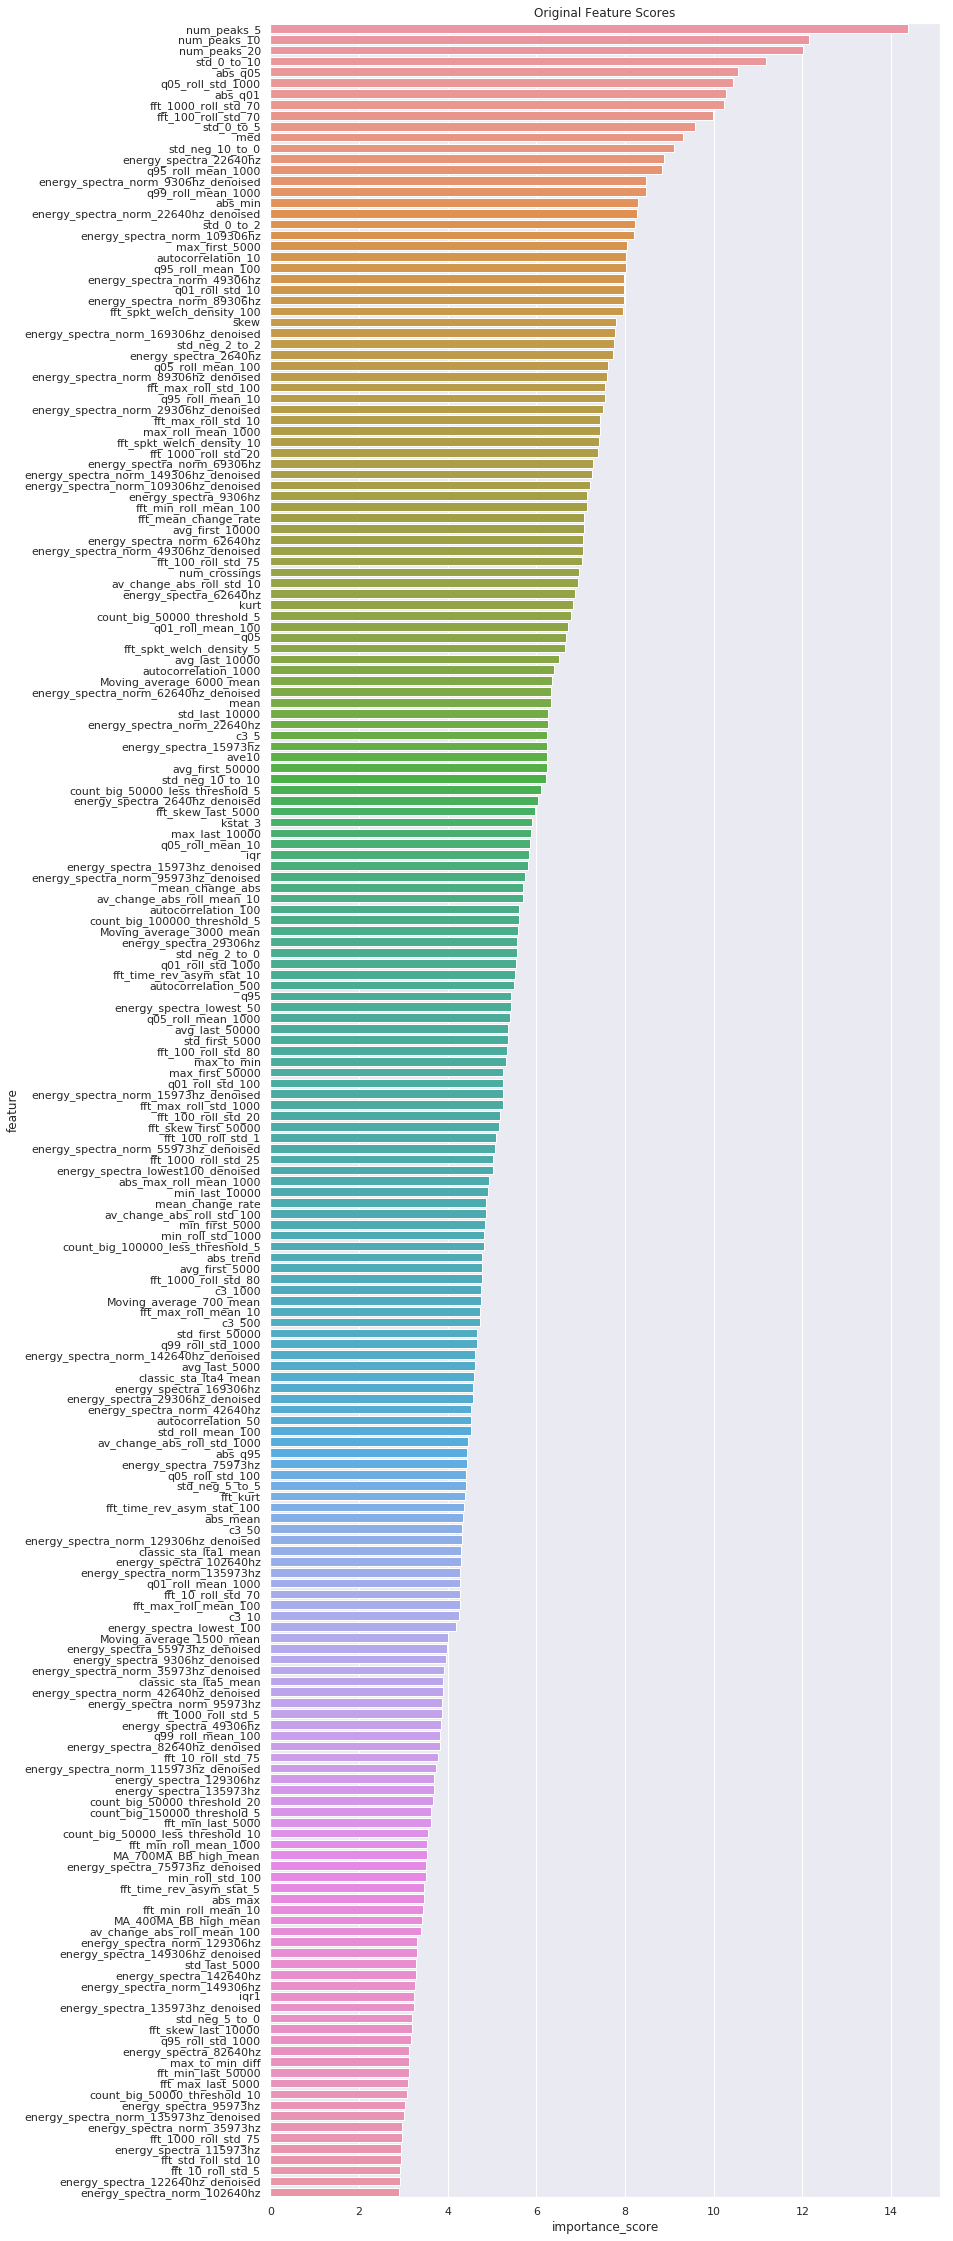

In [36]:
initial_imp_plot = initial_imp[:200]
plot_height = int(np.floor(len(initial_imp_plot)/5))
plt.figure(figsize=(12, plot_height));
sns.barplot(x='importance_score', y='feature', data=initial_imp_plot);
plt.title('Original Feature Scores');

Now we have our baseline feature scores and predictions for the original data.

In [85]:
sub_1 = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')
sub_1['time_to_failure'] = test_preds
sub_1.to_csv('sub_orginal_data.csv', index=False)

# Generate Augmented Data
---
Now that we have established a baseline, we can produce our augmented dataset. In this version I will be substituting 50% of the features in each row with randomly sampled values from that feature's actual distribution.

# Augment data selectively

In [86]:
# index_augment = np.logical_or(y>9, y<2)
index_augment = (y > 9)
# index_augment = np.logical_or(y>10, y<1)
train_select = train[index_augment]
print("No. of samples to be augmented: {}".format(train_select.shape[0]))

No. of samples to be augmented: 812


In [87]:
a = np.arange(0, train.shape[1])
#initialise aug dataframe - remember to set dtype!
train_aug = pd.DataFrame(index=train_select.index, columns=train.columns, dtype='float64')

for i in tqdm_notebook(range(len(train_select))):
    #ratio of features to be randomly sampled
    AUG_FEATURE_RATIO = 0.6
    #to integer count
    AUG_FEATURE_COUNT = np.floor(train_select.shape[1]*AUG_FEATURE_RATIO).astype('int16')
    
    #randomly sample half of columns that will contain random values
    aug_feature_index = np.random.choice(train_select.shape[1], AUG_FEATURE_COUNT, replace=False)
    aug_feature_index.sort()
    
    #obtain indices for features not in aug_feature_index
    feature_index = np.where(np.logical_not(np.in1d(a, aug_feature_index)))[0]
        
    #first insert real values for features in feature_index
    train_aug.iloc[i, feature_index] = train_select.iloc[i, feature_index]
              
    #random row index to randomly sampled values for each features
    rand_row_index = np.random.choice(len(train_select), len(aug_feature_index), replace=True)

    #for each feature being randomly sampled, extract value from random row in train
    for n, j in enumerate(aug_feature_index):
        train_aug.iloc[i, j] = train_select.iloc[rand_row_index[n], j]

Please note that `pandas` will set the datatype of its columns as `'object'` unless you specify otherwise.  I mention this because the above code, which takes less than 1 minute to process 4194 rows of 100 features, will take around an hour if `dtype` isn't set to `'float64'`!

We can see, for a basic sanity check, that for each row in `train_aug` that half the values are the same as in `train`, and the remaining half are seemingly random. The random values for each feature were sampled from that feature's original distribution, and the overall distributions for each variable in `train` shouldn't be very different as a result.

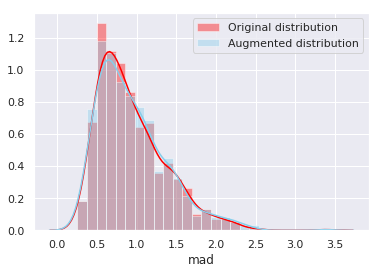

In [90]:
sns.distplot(train_select['mad'], color="red", label="Original distribution")
sns.distplot(train_aug['mad'], color="skyblue", label="Augmented distribution")
plt.legend();

The distributions look almost identical and now we can examine the MAE for the augmented data, along with the feature importances.

# Augmented Data Evaluation
---

The corresponding y-values for the augmented rows will be the same for the original data. We can run `quick_hyperopt()` again to get an idea of the optimal CV score.

In [91]:
train_all = pd.concat([train, train_aug])
y_all = np.append(y, y[index_augment])

print('Original train data shape: {}'.format(train.shape))
print('Augmented train data shape: {}'.format(train_all.shape))

Original train data shape: (4194, 49)
Augmented train data shape: (5006, 49)


In [92]:
params_all = quick_hyperopt(train_all, y_all, 'lgbm', 150)

Running 150 rounds of LightGBM parameter optimisation:
100%|██████████| 150/150 [04:08<00:00,  2.30s/it, best loss: 1.9552222287944698]
{bagging_fraction: 0.56
boosting: gbdt
feature_fraction: 0.58
lambda_l1: 1.0231597269626116
lambda_l2: 2.418442769296895
learning_rate: 0.17651862088375575
max_bin: 197
max_depth: 16
metric: RMSE
min_data_in_bin: 10
min_data_in_leaf: 9
min_gain_to_split: 1.44
num_leaves: 746
objective: huber
subsample: 0.878611343066945}


The combined data has a higher CV, indicating that LightGBM has been less eager to identify predictive feature interactions. Now we can examine the feature importances, and how they have changed relative to the original data. We'll run the augmentation process within a loop to ensure an even distribution of random features.

In [96]:
imp_split_all = np.zeros(train_aug.shape[1])
imp_gain_all = np.zeros(train_aug.shape[1])
test_preds_aug = np.zeros(len(test)) 
train_preds_aug = np.zeros(len(train_all)) 

N = 30
for i in tqdm_notebook(range(N)):
    
    a = np.arange(0, train_select.shape[1])
    np.random.seed(i)
    train_aug = pd.DataFrame(index=train_select.index, columns=train.columns, dtype='float64')

    for i in range(0, len(train_select)):
        #ratio of features to be randomly sampled
        AUG_FEATURE_RATIO = 0.6
        #to integer count
        AUG_FEATURE_COUNT = np.floor(train_select.shape[1]*AUG_FEATURE_RATIO).astype('int16')
    
        #randomly sample half of columns that will contain random values
        aug_feature_index = np.random.choice(train_select.shape[1], AUG_FEATURE_COUNT, replace=False)
        aug_feature_index.sort()
    
        #obtain indices for features not in aug_feature_index
        feature_index = np.where(np.logical_not(np.in1d(a, aug_feature_index)))[0]
        
        #first insert real values for features in feature_index
        train_aug.iloc[i, feature_index] = train_select.iloc[i, feature_index]
              
        #random row index to randomly sampled values for each features
        rand_row_index = np.random.choice(len(train_select), len(aug_feature_index), replace=True)
        
        #for each feature being randomly sampled, extract value from random row in train
        for n, j in enumerate(aug_feature_index):
            train_aug.iloc[i, j] = train_select.iloc[rand_row_index[n], j]
    
    
    train_all = pd.concat([train, train_aug])
        
    imp_s, imp_g, preds, oof_preds = quick_kfold_imp(train_all, y_all, test, 
                                                     params=params_all, random_state=i)
    imp_split_all += imp_s/N
    imp_gain_all += imp_g/N
    test_preds_aug += preds/N
    train_preds_aug += oof_preds/N


OOF MAE: 2.0362095
OOF MAE: 2.0216630
OOF MAE: 2.0322860
OOF MAE: 2.0275111
OOF MAE: 2.0141723
OOF MAE: 2.0316017
OOF MAE: 2.0289560
OOF MAE: 2.0371534
OOF MAE: 2.0378579
OOF MAE: 2.0347399
OOF MAE: 2.0248289
OOF MAE: 2.0305759
OOF MAE: 2.0359781
OOF MAE: 2.0208970
OOF MAE: 2.0285687
OOF MAE: 2.0302209
OOF MAE: 2.0369547
OOF MAE: 2.0364826
OOF MAE: 2.0356869
OOF MAE: 2.0259955
OOF MAE: 2.0197829
OOF MAE: 2.0307294
OOF MAE: 2.0325033
OOF MAE: 2.0341608
OOF MAE: 2.0254458
OOF MAE: 2.0371144
OOF MAE: 2.0287955
OOF MAE: 2.0357396
OOF MAE: 2.0331675
OOF MAE: 2.0311606



In [97]:
_train_preds_aug = train_preds_aug[:NUM_SEGMENTS]
print("OOF mae for different time_to_failure after data augmentation:")
print("MAE for ttf>11   = {:.5f}".format(mean_absolute_error(y[index1], _train_preds_aug[index1])))
print("MAE for 9<ttf<11 = {:.5f}".format(mean_absolute_error(y[index2], _train_preds_aug[index2])))
print("MAE for 7<ttf<9  = {:.5f}".format(mean_absolute_error(y[index3], _train_preds_aug[index3])))
print("MAE for 5<ttf<7  = {:.5f}".format(mean_absolute_error(y[index4], _train_preds_aug[index4])))
print("MAE for 3<ttf<5  = {:.5f}".format(mean_absolute_error(y[index5], _train_preds_aug[index5])))
print("MAE for 1<ttf<3  = {:.5f}".format(mean_absolute_error(y[index6], _train_preds_aug[index6])))
print("MAE for ttf<1    = {:.5f}".format(mean_absolute_error(y[index7], _train_preds_aug[index7])))

OOF mae for different time_to_failure after data augmentation:
MAE for ttf>11   = 4.05534
MAE for 9<ttf<11 = 2.41610
MAE for 7<ttf<9  = 1.78841
MAE for 5<ttf<7  = 1.75102
MAE for 3<ttf<5  = 1.38691
MAE for 1<ttf<3  = 1.29562
MAE for ttf<1    = 3.04997


In [98]:
aug_imp = pd.DataFrame({'feature':train_features,
                          'importance_split':imp_split_all,
                          'importance_gain':imp_gain_all,
                          'importance_score':np.log((imp_split_all*imp_gain_all))})

In [99]:
aug_imp.sort_values('importance_score', ascending=False, inplace=True)
list(aug_imp.feature.values[:20])

['num_peaks_10',
 'std_0_to_10',
 'fft_100_roll_std_70',
 'num_crossings',
 'abs_q01',
 'mad',
 'q05_roll_std_1000',
 'fft_100_roll_std_20',
 'med',
 'std_neg_10_to_0',
 'q05_roll_mean_100',
 'count_big_50000_threshold_5',
 'std_neg_2_to_2',
 'q99_roll_mean_1000',
 'abs_min',
 'energy_spectra_norm_49306hz_denoised',
 'abs_max_roll_mean_1000',
 'q95_roll_mean_100',
 'max_first_5000',
 'c3_5']

From inspection, the most important features appear to have changed. 

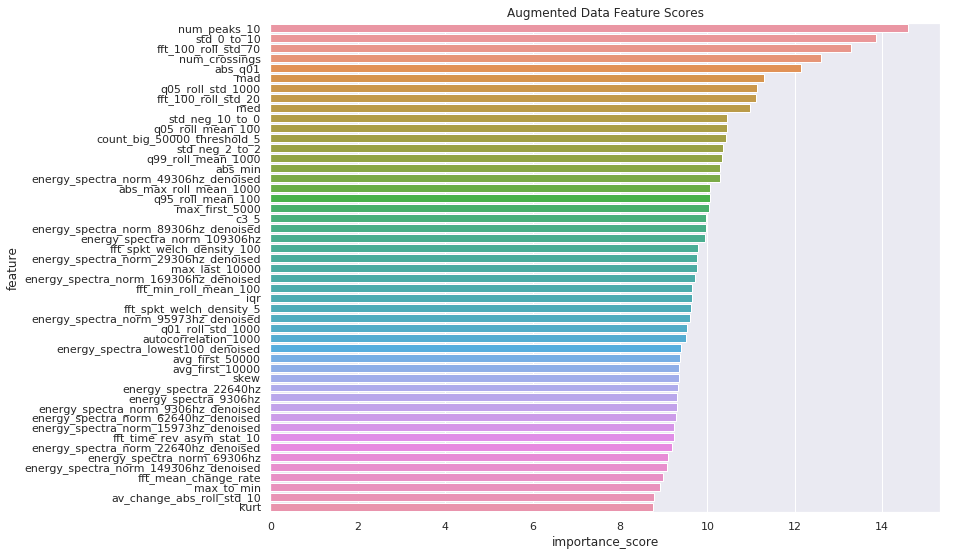

In [100]:
aug_imp_plot = aug_imp.iloc[:100]
plot_height = int(np.floor(len(aug_imp_plot)/5))
plt.figure(figsize=(12, plot_height));
sns.barplot(x='importance_score', y='feature', data=aug_imp_plot);
plt.title('Augmented Data Feature Scores');
plt.show()

We can then prepare a submission made with the augmented data and its different feature importances for comparison.

In [101]:
sub_aug = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')
sub_aug['time_to_failure'] = test_preds_aug
sub_aug.to_csv('sub_aug_data.csv', index=False)

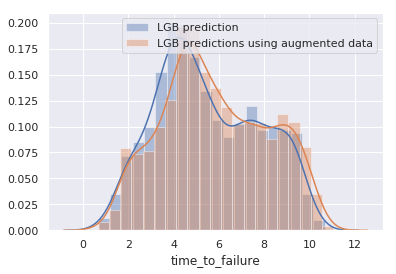

In [102]:
sns.distplot(sub_1['time_to_failure'], label='LGB prediction')
sns.distplot(sub_aug['time_to_failure'], label='LGB predictions using augmented data')
plt.legend();

# Feature Importance Change
---

So what is the relative change in feature importance for each feature? LightGBM can be inconsistent with feature importance scores so they'll have to be scaled.

In [103]:
from sklearn.preprocessing import MinMaxScaler

In [104]:
initial_imp.loc[initial_imp.importance_score<-100, 'importance_score'] = -50
aug_imp.loc[aug_imp.importance_score<-100,'importance_score'] = -100
scaler = MinMaxScaler()
initial_imp.iloc[:, 1:] = scaler.fit_transform(initial_imp.iloc[:, 1:])
scaler = MinMaxScaler()
aug_imp.iloc[:, 1:] = scaler.fit_transform(aug_imp.iloc[:, 1:])

In [105]:
aug_cols = ['feature'] + [x + '_all' for x in aug_imp.columns if x != 'feature']
aug_imp.columns = aug_cols
feature_df = initial_imp.merge(aug_imp, on='feature', how='inner')
feature_df['score_change'] = feature_df['importance_score_all'] - feature_df['importance_score']
feature_df.sort_values('score_change', ascending=False, inplace=True)
feature_df.head(10)

,feature,importance_split,importance_gain,importance_score,importance_split_all,importance_gain_all,importance_score_all,score_change
48,mad,0.000000,0.000000,0.000000,0.349385,0.057524,0.433866,0.433866
2,fft_100_roll_std_70,0.239462,0.259347,0.643683,0.527772,0.393503,0.776562,0.132879
4,num_crossings,0.138826,0.157784,0.532982,0.511163,0.198656,0.660208,0.127226
1,std_0_to_10,0.333948,0.490302,0.769732,0.668195,0.611587,0.873162,0.103431
14,fft_100_roll_std_20,0.245337,0.026901,0.324076,0.557970,0.036070,0.405165,0.081089
28,std_neg_2_to_2,0.376922,0.007821,0.238554,0.578893,0.011807,0.274132,0.035578
3,abs_q01,0.369201,0.116127,0.557764,0.746711,0.096579,0.580631,0.022867
40,q95_roll_mean_100,0.250256,0.008033,0.206069,0.384545,0.010053,0.223853,0.017784
7,med,0.604086,0.021037,0.379257,0.846851,0.021627,0.380321,0.001063
0,num_peaks_10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


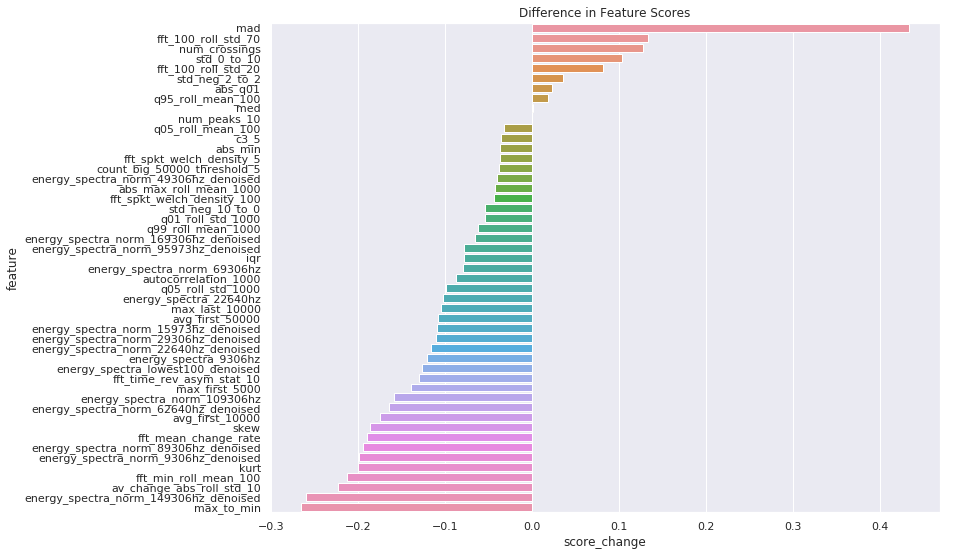

In [106]:
plot_height = int(np.floor(len(feature_df)/5))
plt.figure(figsize=(12, plot_height));
sns.barplot(x='score_change', y='feature', data=feature_df);
plt.title('Difference in Feature Scores');

This has clearly identified some features that became *less* valuable when more randomness is introduced into the dataset.  This indicates that these particular features may have been attributed weight by the model due to random variance instead of a genuine relationship with the target. As a last experiment, we can isolate the features whose change in feature importance was in the bottom two quintiles and remove them. Their predictions can then be evaluated on the test set.

In [107]:
MIN_SCORE = np.percentile(feature_df.score_change.values.flatten(), 20)
best_features = feature_df.loc[feature_df.score_change >= MIN_SCORE, :].feature.values.flatten()
train = train[best_features]
test = test[best_features]
train_select = train[index_augment]

In [109]:
params_final = quick_hyperopt(train, y, 'lgbm', 150)

Running 150 rounds of LightGBM parameter optimisation:
100%|██████████| 150/150 [01:54<00:00,  1.09it/s, best loss: 2.0024738271698515]
{bagging_fraction: 0.72
boosting: goss
feature_fraction: 0.81
lambda_l1: 4.1192081329187085
lambda_l2: 4.315621163484001
learning_rate: 0.05717937258650297
max_bin: 87
max_depth: 7
metric: RMSE
min_data_in_bin: 147
min_data_in_leaf: 16
min_gain_to_split: 4.36
num_leaves: 194
objective: fair
other_rate: 0.1833544556573913
top_rate: 0.4588882312192332}


In [110]:
train_preds_final = np.zeros(len(train_all))
test_preds_final = np.zeros(len(test)) 

N = 30
for i in tqdm_notebook(range(N)):
    
    a = np.arange(0, train_select.shape[1])
    np.random.seed(i)
    train_aug = pd.DataFrame(index=train_select.index, columns=train.columns, dtype='float64')

    for i in range(len(train_select)):
        #ratio of features to be randomly sampled
        AUG_FEATURE_RATIO = 0.6
        #to integer count
        AUG_FEATURE_COUNT = np.floor(train_select.shape[1]*AUG_FEATURE_RATIO).astype('int16')
    
        #randomly sample half of columns that will contain random values
        aug_feature_index = np.random.choice(train_select.shape[1], AUG_FEATURE_COUNT, replace=False)
        aug_feature_index.sort()
    
        #obtain indices for features not in aug_feature_index
        feature_index = np.where(np.logical_not(np.in1d(a, aug_feature_index)))[0]
        
        #first insert real values for features in feature_index
        train_aug.iloc[i, feature_index] = train_select.iloc[i, feature_index]
              
        #random row index to randomly sampled values for each features
        rand_row_index = np.random.choice(len(train_select), len(aug_feature_index), replace=True)
        
        #for each feature being randomly sampled, extract value from random row in train
        for n, j in enumerate(aug_feature_index):
            train_aug.iloc[i, j] = train_select.iloc[rand_row_index[n], j]
    
    
    train_all = pd.concat([train, train_aug])
        
    _,  _, preds, tr_preds = quick_kfold_imp(train_all, y_all, test, 
                                             params=params_final, random_state=i)
    test_preds_final += preds/N
    train_preds_final += tr_preds/N

OOF MAE: 2.0368067
OOF MAE: 2.0316209
OOF MAE: 2.0319736
OOF MAE: 2.0383090
OOF MAE: 2.0520397
OOF MAE: 2.0340842
OOF MAE: 2.0324323
OOF MAE: 2.0345105
OOF MAE: 2.0288067
OOF MAE: 2.0522585
OOF MAE: 2.0382528
OOF MAE: 2.0344847
OOF MAE: 2.0387202
OOF MAE: 2.0463625
OOF MAE: 2.0250896
OOF MAE: 2.0341837
OOF MAE: 2.0332618
OOF MAE: 2.0355881
OOF MAE: 2.0291737
OOF MAE: 2.0406240
OOF MAE: 2.0349792
OOF MAE: 2.0378893
OOF MAE: 2.0315163
OOF MAE: 2.0301958
OOF MAE: 2.0304880
OOF MAE: 2.0471570
OOF MAE: 2.0326408
OOF MAE: 2.0420635
OOF MAE: 2.0392572
OOF MAE: 2.0424989



In [111]:
sub_final = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')
sub_final['time_to_failure'] = test_preds_final
sub_final.to_csv('sub_quintile_features_removed.csv', index=False)

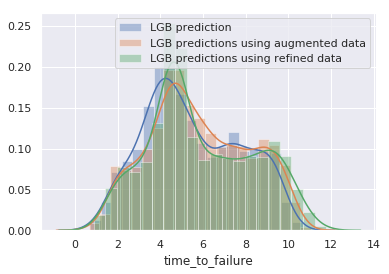

In [112]:
sns.distplot(sub_1['time_to_failure'], label='LGB prediction')
sns.distplot(sub_aug['time_to_failure'], label='LGB predictions using augmented data')
sns.distplot(sub_final['time_to_failure'], label='LGB predictions using refined data')
plt.legend();

# Check MAE for different TTF

In [113]:
_train_preds_final = train_preds_final[:NUM_SEGMENTS]
print("OOF mae for different time_to_failure for refined data:")
print("MAE for ttf>11   = {:.5f}".format(mean_absolute_error(y[index1], _train_preds_final[index1])))
print("MAE for 9<ttf<11 = {:.5f}".format(mean_absolute_error(y[index2], _train_preds_final[index2])))
print("MAE for 7<ttf<9  = {:.5f}".format(mean_absolute_error(y[index3], _train_preds_final[index3])))
print("MAE for 5<ttf<7  = {:.5f}".format(mean_absolute_error(y[index4], _train_preds_final[index4])))
print("MAE for 3<ttf<5  = {:.5f}".format(mean_absolute_error(y[index5], _train_preds_final[index5])))
print("MAE for 1<ttf<3  = {:.5f}".format(mean_absolute_error(y[index6], _train_preds_final[index6])))
print("MAE for ttf<1    = {:.5f}".format(mean_absolute_error(y[index7], _train_preds_final[index7])))

OOF mae for different time_to_failure for refined data:
MAE for ttf>11   = 3.69499
MAE for 9<ttf<11 = 2.31585
MAE for 7<ttf<9  = 1.88519
MAE for 5<ttf<7  = 1.91985
MAE for 3<ttf<5  = 1.40494
MAE for 1<ttf<3  = 1.27642
MAE for ttf<1    = 3.04327


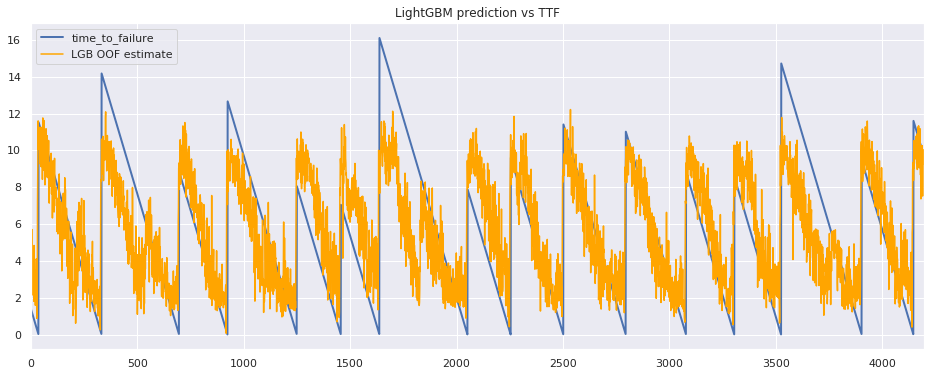

In [115]:
plt.figure(figsize=(16, 6))
plt.plot(y, color='b', label='time_to_failure', linewidth = 2)
plt.plot(train_preds_final[:NUM_SEGMENTS], color='orange', label='LGB OOF estimate')
plt.legend(loc='best')
plt.autoscale(axis='x', tight=True)
plt.title('LightGBM prediction vs TTF');